# Rock-Paper-Scissors Prompt Order Analysis

This notebook analyzes the results of the RPS game experiment. The goal is to determine whether the order in which choices are presented in the prompt affects the model's selection probabilities for rock, paper, or scissors.

We will:
- Load the RPS experiment results.
- Map model output tokens to canonical choices.
- Calculate the probability distribution for each choice based on logprobs.
- Aggregate and visualize the results by prompt order.
- Investigate if prompt order introduces any bias in the model's choices.

## Setup and Data Loading

First, import the necessary libraries and load the RPS results.

In [1]:
# Install dependencies if needed
%pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Load the RPS results
RESULTS_FILE = 'rps_results_order.json'
with open(RESULTS_FILE, 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results)
df.head()

,prompt_order,response,logprobs
0,"[rock, paper, scissors]",scissors,"[{'token': 'rock', 'logprob': -1.2877055406570..."
1,"[rock, paper, scissors]",scissors,"[{'token': 'Rock', 'logprob': -0.9437826275825..."
2,"[rock, paper, scissors]",rock,"[{'token': 'rock', 'logprob': -1.2263624668121..."
3,"[rock, paper, scissors]",paper.,"[{'token': 'Sc', 'logprob': -0.887918770313262..."
4,"[rock, paper, scissors]",scissors,"[{'token': 'Rock', 'logprob': -0.8340977430343..."


## Token Mapping

Map the first token in the model's response to the canonical choices: rock, paper, or scissors.

In [3]:
token_to_choice = {
    'rock': 'rock',
    'Rock': 'rock',
    'RO': 'rock',
    ' paper': 'paper',
    'paper': 'paper',
    'Paper': 'paper',
    'P': 'paper',
    'scissors': 'scissors',
    'Scissors': 'scissors',
    'sc': 'scissors',
    'Sc': 'scissors',
    'SC': 'scissors',
    ' scissors': 'scissors',
    ' rock': 'rock',

}

## Calculate Choice Probabilities

For each response, calculate the probability assigned to each choice using the logprobs.

In [4]:
def calculate_choice_probabilities(logprobs_list):
    prob_rock = 0.0
    prob_paper = 0.0
    prob_scissors = 0.0
    for entry in logprobs_list:
        token = entry['token']
        logprob = entry['logprob']
        prob = math.exp(logprob)
        choice = token_to_choice.get(token)
        if choice == 'rock':
            prob_rock += prob
        elif choice == 'paper':
            prob_paper += prob
        elif choice == 'scissors':
            prob_scissors += prob
    return prob_rock, prob_paper, prob_scissors

## Apply Probability Calculation

Apply the probability calculation to each row and add the results as new columns.

In [5]:
probs = df['logprobs'].apply(lambda x: pd.Series(calculate_choice_probabilities(x), 
                                                index=['prob_rock', 'prob_paper', 'prob_scissors']))
df = pd.concat([df, probs], axis=1)
df.head()

,prompt_order,response,logprobs,prob_rock,prob_paper,prob_scissors
0,"[rock, paper, scissors]",scissors,"[{'token': 'rock', 'logprob': -1.2877055406570...",0.490777,0.061562,0.429747
1,"[rock, paper, scissors]",scissors,"[{'token': 'Rock', 'logprob': -0.9437826275825...",0.625186,0.067625,0.295317
2,"[rock, paper, scissors]",rock,"[{'token': 'rock', 'logprob': -1.2263624668121...",0.586715,0.065457,0.336388
3,"[rock, paper, scissors]",paper.,"[{'token': 'Sc', 'logprob': -0.887918770313262...",0.286205,0.194384,0.503332
4,"[rock, paper, scissors]",scissors,"[{'token': 'Rock', 'logprob': -0.8340977430343...",0.558685,0.096898,0.338860


## Analyze by Prompt Order

Aggregate the probabilities by the order in which choices were presented in the prompt.

In [6]:
# Convert prompt_order to a string for grouping
df['prompt_order_str'] = df['prompt_order'].apply(lambda x: ','.join(x))

grouped = df.groupby('prompt_order_str')[['prob_rock', 'prob_paper', 'prob_scissors']].mean().reset_index()
grouped

,prompt_order_str,prob_rock,prob_paper,prob_scissors
0,"paper,rock,scissors",0.525358,0.046064,0.424619
1,"paper,scissors,rock",0.751692,0.061961,0.178351
2,"rock,paper,scissors",0.393493,0.117754,0.480987
3,"rock,scissors,paper",0.370781,0.406898,0.202285
4,"scissors,paper,rock",0.588744,0.117126,0.279722
5,"scissors,rock,paper",0.665000,0.124016,0.201737


## Visualization

Visualize the mean probability for each choice as a function of prompt order.

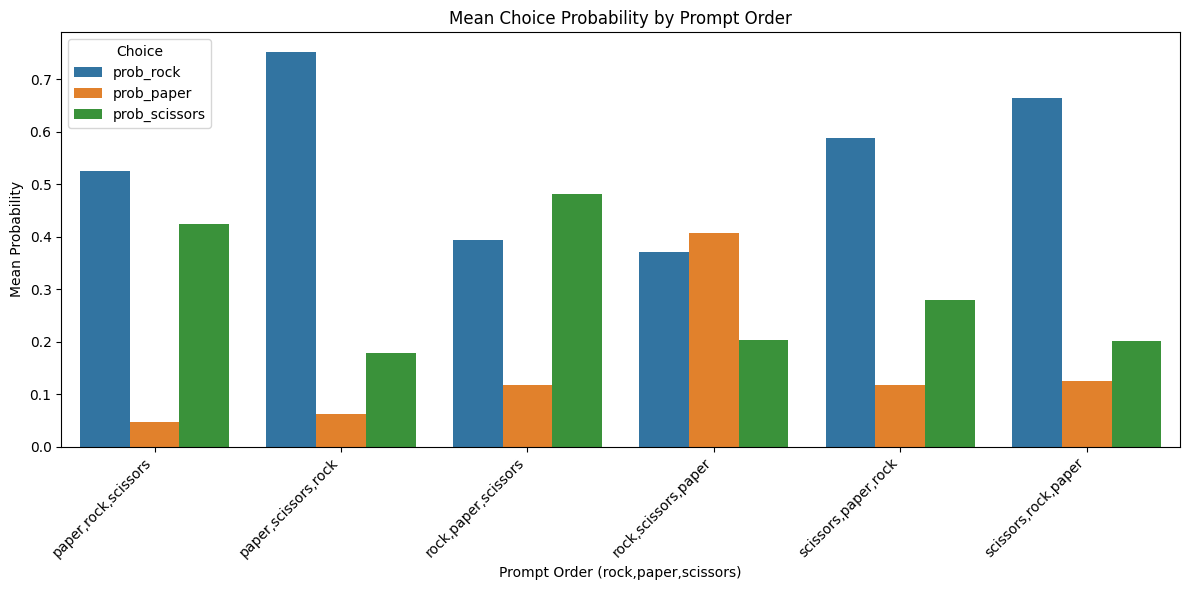

In [7]:
grouped_melted = grouped.melt(id_vars='prompt_order_str', 
                              value_vars=['prob_rock', 'prob_paper', 'prob_scissors'], 
                              var_name='choice', value_name='mean_probability')

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_melted, x='prompt_order_str', y='mean_probability', hue='choice')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Choice Probability by Prompt Order')
plt.ylabel('Mean Probability')
plt.xlabel('Prompt Order (rock,paper,scissors)')
plt.legend(title='Choice')
plt.tight_layout()
plt.show()

## Conclusion

By examining the mean probabilities for each choice across different prompt orders, we can assess whether the order of presentation influences the model's selection. If a particular choice is consistently favored when it appears first, second, or third, this may indicate a prompt order bias.